# Switch Analysis
##### David M. Freestone & Fuat Balci
March 14, 2016

### 1.0 Introduction

This jupyter notebook shows how to analyze the data collected using the Psychopy Switch experiment accompanying xxx (the chapter).

First, we need to tell Python what packages and functions we'll use in this analysis script. They come in the form of import statements

In [116]:
from glob import glob     # for finding data files
from os.path import join  # for dealing with path names easily
from ast import literal_eval # for converting a string of a list into a list

from pandas import read_csv, concat, isnull     # reading in the data
from scipy.stats import invgauss, expon, norm # useful distributions
from scipy.optimize import minimize     # gradient descent fitting
from numpy import array, arange, log, sqrt, hstack     # some math functions

from matplotlib.pyplot import subplots, style  # for plotting
style.use("fivethirtyeight")                   # set figure style

# Import entire packages, so we can explore later.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Needed so plots show up in the jupyter notebook
%matplotlib inline

# Matplotlib spits out an annoying FutureWarning that we don't care about.
# Suppress it
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

Next we define the data directory, find all the ".csv" files in the directory, and load them all into a pandas DataFrame

In [123]:
data_directory = "data"
data_files = glob(join(data_directory, "*.csv"))
data = concat([read_csv(f) for f in data_files])

There are a lot of columns in this dataset that we'll probably never use (i.e., frameRate). It makes looking at the data easier if we remove them.

We'll also remove any event that isn't a response (like the introduction and break screens).

In [124]:
columns = ["participant", "session", "date", "time", 
           "block_number", "interval", "trial_number", 
           "response", "response_time", "score"]
trial_idx = data.trial_number > 0
data = data.ix[trial_idx, columns]

##### 1.1 Switch times

The key datum in the analysis are the switch times per trial. For completeness, the Psychopy Switch task records every response, not just the time of the switch. So we have to get the time of the switch per trial.

There are a few things that can go wrong, though. For example, the participant could never switch by either pressing the short the entire time or pressing the long the entire time. Or, the participant can switch back to the short after already switching to the long. These cases may be interesting to study, but we'll remove them and only deal with "clean" trials.

In [125]:
def switch_time(df):
    """Return the switch time on a single trial"""
    short_times = df[df.response=="left"].response_time
    long_times = df[df.response=="right"].response_time
    
    if (short_times.size < 1) or (long_times.size < 1):
        # Didn't press one of the options, no switch
        return None
    elif short_times.max() > long_times.min():
        # switched back to short at some point, no switch
        return None
    return long_times.iloc[0]     

We get the switch times per subject, session, and trial, and only for long trials.

In [126]:
long_trials = data.interval == 3
group = ["participant", "session", "trial_number"]

data = (data[long_trials].groupby(group)
        .apply(switch_time)
        .pipe(pd.DataFrame)
        .rename(columns={0:"switch_time"})
        .reset_index()
        .dropna())

### 2.0 Summary measures

##### 2.1 Summary statistics

In [127]:
group = ["participant", "session"]
data.groupby(group).switch_time.describe()

participant  session       
DMF          1        count    16.000000
                      mean      2.338386
                      std       0.276139
                      min       1.787769
                      25%       2.179765
                      50%       2.289071
                      75%       2.531547
                      max       2.840237
             2        count    12.000000
                      mean      2.279327
                      std       0.424068
                      min       1.704105
                      25%       1.913127
                      50%       2.272356
                      75%       2.673367
                      max       2.873847
FB           1        count    16.000000
                      mean      2.270374
                      std       0.287839
                      min       1.871740
                      25%       2.045586
                      50%       2.255689
                      75%       2.426320
                      max    

In [128]:
data.groupby(group).switch_time.agg(["mean", "std", "sem"])

mean       std       sem
participant session                              
DMF         1        2.338386  0.276139  0.069035
            2        2.279327  0.424068  0.122418
FB          1        2.270374  0.287839  0.071960
            2        2.244832  0.346908  0.092715

##### 2.2 Scatter Plots

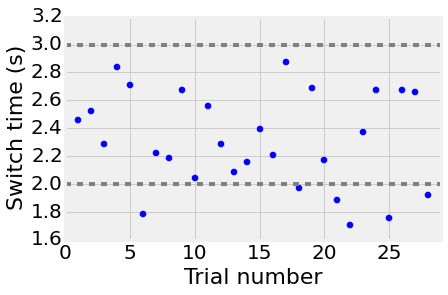

In [129]:
idx = data.participant=="DMF"
y = data[idx].switch_time
x = arange(1, y.size+1)

fig, ax = subplots()
ax.scatter(x, y, s=50)
ax.hlines([2, 3], [0]*2, [1+x.max()]*2,
          linestyle="--", color="gray")

# Modify the axes
ax.set_xlim((0, 1+x.max()))
ax.set_xlabel("Trial number", fontsize=22)
ax.set_ylabel("Switch time (s)", fontsize=22)
ax.tick_params(labelsize=20)

##### 2.3 Histograms

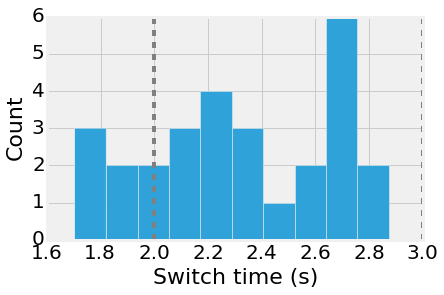

In [130]:
# Plot a histogram of the response times
ax = data[data.participant=="DMF"].switch_time.hist();

# plot a line at the DRL schedule
ymin, ymax = ax.get_ylim()
ax.vlines([2, 3], [ymin]*2, [ymax]*2, 
          linestyle="--", color="gray")

# Label the x and y axes, and change the tick label size
ax.set_xlabel("Switch time (s)", fontsize=22)
ax.set_ylabel("Count", fontsize=22)
ax.tick_params(labelsize=20)

### 3.0 Fitting the switch time distribution


In humans and rats, the switch times are normally distributed. In mice, they are sometimes a mixture distribution of an exponential and a Gaussian. The "DRL_Analysis" code shows how to fit a mixture distribution.

Since humans and rats show normally distributed switch times, the maximum likelihood estimates of the parameters are the mean and standard deviation.

In [140]:
# Can "fit" analytically since the parameters are μ=mean and σ=standard deviation
fit_results = switch_df.groupby(["participant"]).switch_time.agg(["mean", "std"])
fit_results = fit_results.rename(columns={"mean": "μ", "std": "σ"})

##### 3.2 Visualizing the fits


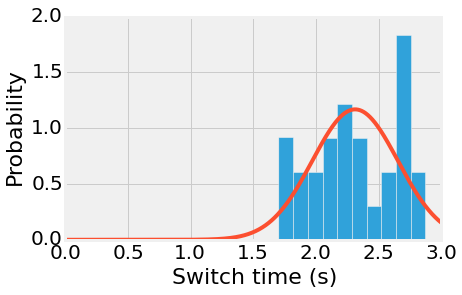

In [142]:
participant = "DMF"
# Pull out the parameters for one participant (and convert to a matrix)
params = fit_results.ix[participant, ["μ", "σ"]].as_matrix()

x = np.linspace(0, 3, 1000)

st = data[data.participant==participant].switch_time.as_matrix()
st_fit = norm.pdf(x, *params)

# Plot
fig, ax = subplots()
ax.hist(st, bins=10, normed=True);
ax.plot(x, st_fit)

# Modify the axes
ax.set_xlabel("Switch time (s)", fontsize=22)
ax.set_ylabel("Probability", fontsize=22)
ax.tick_params(labelsize=20)

### 4.0 Assessing Optimality